# Tensor Processing Units (TPUs)
![](https://storage.googleapis.com/gweb-uniblog-publish-prod/original_images/tpu-v2-hero-2.png)

A tensor processing unit (TPU) is an AI accelerator application-specific integrated circuit (ASIC) developed by Google specifically for neural network machine learning. Kaggle provides us TPUv3 it is with a speed of **420 teraflops 128 GB HBM**. To go fast on a TPU, increase the batch size. **The rule of thumb is to use batches of 128 elements per core till 8 cores then inrese it accordingly.** When we give large batch size we need to give higher learning rate.

When Google designed the TPU, we built a domain-specific architecture. That means, instead of designing a general purpose processor, we designed it as a matrix processor specialized for neural network work loads. TPUs can't run word processors, control rocket engines, or execute bank transactions, but they can handle the massive multiplications and additions for neural networks, at blazingly fast speeds while consuming much less power and inside a smaller physical footprint.

Then, the TPU loads data from memory. As each multiplication is executed, the result will be passed to next multipliers while taking summation at the same time. So the output will be the summation of all multiplication result between data and parameters. During the whole process of massive calculations and data passing, no memory access is required at all.

To undersand how TPU works withrespect to GPU see the GIF below,
![](https://storage.googleapis.com/gweb-cloudblog-publish/original_images/image4_5PFB45w.gif)

# How to use it in kaggle???
select `TPU v3-8` from Accelerator option in bottom left
### 1)
![](https://i.ibb.co/805D017/Screenshot-2020-02-18-Complex-Res-Net-TPU-vs-GPU-benchmark-Kaggle.png)
### 2)
![](https://i.ibb.co/XtjyFqJ/Screenshot-2020-02-18-Complex-Res-Net-TPU-vs-GPU-benchmark-Kaggle-1.png)

## Load All Libraries

In [1]:
# Load the Libs.....
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
AUTO = tf.data.experimental.AUTOTUNE


import numpy as np
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import clone_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import datetime as dt

import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
AUTO = tf.data.experimental.AUTOTUNE


Using TensorFlow backend.


In [2]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"

## Confirm TPU is running

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  grpc://10.0.0.2:8470


In [4]:
IMAGE_SIZE = [512, 512] # The Main Use of TPU Less memory usage so feel free to se the largest
EPOCHS = 100
BATCH_SIZE = 128

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
#print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

In [6]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Dataset visualizations

In [7]:
%%time
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [103 100  53 ...  67   0  28]
Validation data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Validation data label examples: [53 67 15 ... 49 68 75]
Test data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Test data IDs: ['5fdf59f6f' '2198f8dae' '6a6ad6ad3' ... 'd8437a7f7' '3a01c3e88' '981396649']
CPU times: user 2.39 s, sys: 4.91 s, total: 7.3 s
Wall time: 12.8 s


In [8]:
%%time
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

CPU times: user 47.5 ms, sys: 352 µs, total: 47.9 ms
Wall time: 45.4 ms


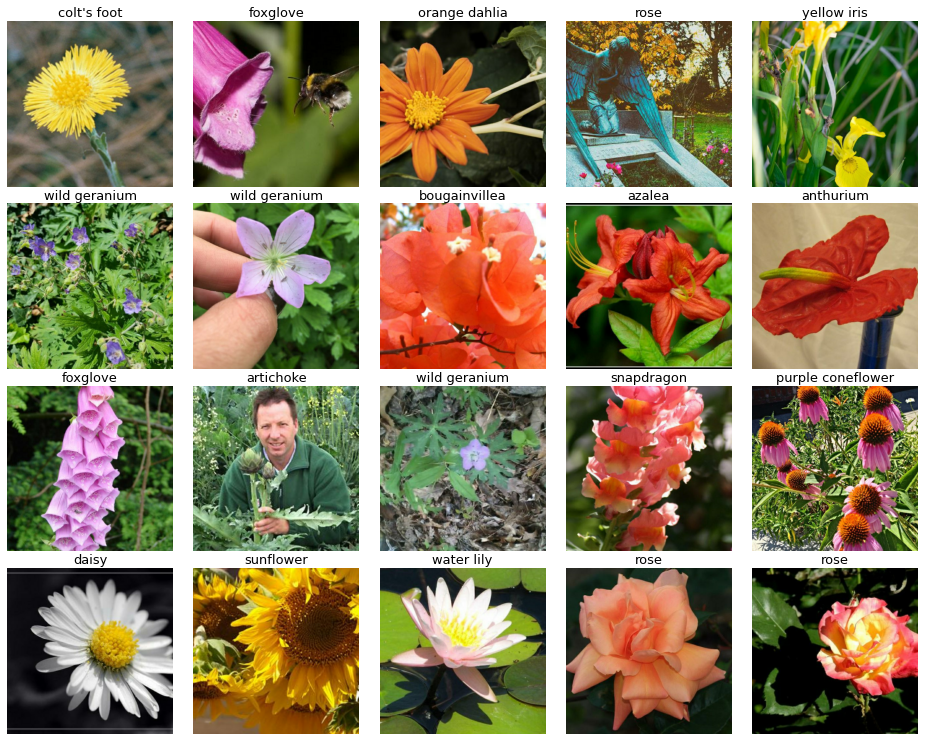

CPU times: user 2.23 s, sys: 384 ms, total: 2.62 s
Wall time: 3.47 s


In [9]:
%%time
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

In [10]:
%%time
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

CPU times: user 29 ms, sys: 1.69 ms, total: 30.7 ms
Wall time: 62.1 ms


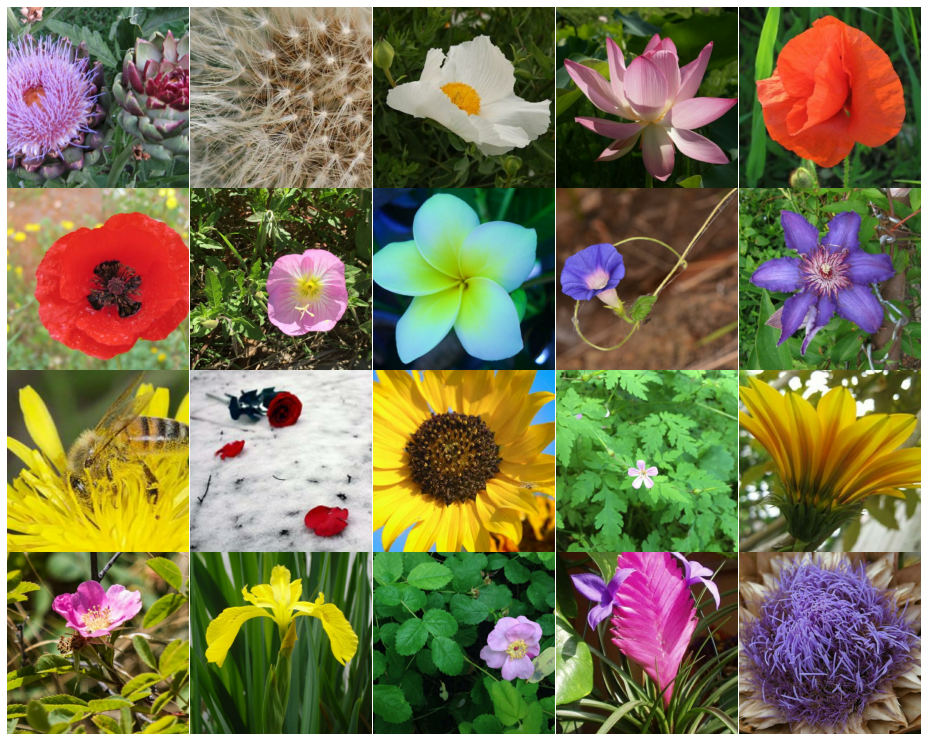

CPU times: user 2.26 s, sys: 415 ms, total: 2.68 s
Wall time: 2.81 s


In [11]:
%%time
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

In [12]:
%%time
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

CPU times: user 151 µs, sys: 0 ns, total: 151 µs
Wall time: 158 µs


# Design model
### Don't worry!! get weird with your creation

In [13]:
def res_net_block(input_data, filters,fsize,pool = False):
  #fsize = (3,3)
  res = input_data


  if pool:
        input_data = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(input_data)
        input_data = layers.Conv2D(filters, kernel_size=(1, 1), strides=(1,1), padding='same')(input_data)
        res = layers.BatchNormalization()(input_data)   
        #res = tfa.layers.GroupNormalization(groups=32)(input_data)   


  x1 =  layers.BatchNormalization()(input_data)
  x1 = layers.Conv2D(filters, fsize, activation='relu', padding='same')(x1)
  x1 = tf.nn.leaky_relu(x1, alpha=0.01, name='Leaky_ReLU')
  x1 = layers.Dropout(0.1)(x1)
  #x1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x1)

  if pool:
    x1 =  layers.BatchNormalization()(x1)
    x1 = tf.nn.leaky_relu(x1, alpha=0.01, name='Leaky_ReLU') 
    x1 = layers.Conv2D(filters=filters, kernel_size=fsize, strides=[1, 1], padding="same")(x1)
    

    #x2 = layers.Dropout(0.2)(x2)
    
  '''  
  x5 = layers.Conv2D(filters, 1, activation=None, padding='same')(input_data)
  x5 = tf.nn.leaky_relu(x5, alpha=0.01, name='Leaky_ReLU') '''

  x = layers.Add()([ x1 , res ])
  x = tf.nn.leaky_relu(x, alpha=0.01, name='Leaky_ReLU') 
  return x

In [14]:
def res_net_block_2(input_data, filters):
  
    x1 = layers.Conv2D(filters, 3, activation='relu', padding='same')(input_data)
    x1 = tf.nn.leaky_relu(x1, alpha=0.01, name='Leaky_ReLU') 
    x2 = layers.BatchNormalization()(x1)
    x2 = layers.Dropout(0.1)(x2)
    
    x3 = layers.Conv2D(filters, 5, activation=None, padding='same')(input_data)
    x3 = tf.nn.leaky_relu(x3, alpha=0.01, name='Leaky_ReLU') 
    x4 = layers.BatchNormalization()(x3)
    x4 = layers.Dropout(0.1)(x4)
  
    x5 = layers.Conv2D(filters, 1, activation=None, padding='same')(input_data)
    x5 = tf.nn.leaky_relu(x5, alpha=0.01, name='Leaky_ReLU') 

    x = layers.Add()([x2 , x4 , x5 ])
    x = layers.Activation('relu')(x)
    return x

In [15]:
def hybridnet():
    inputs = keras.Input(shape=(512,512,3))

    
    
    x = layers.Conv2D(64, (5, 5), strides = (2, 2), name = 'conv1')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.nn.leaky_relu(x, alpha=0.01, name='Leaky_ReLU') 
    x = layers.MaxPooling2D(3)(x)
    x = layers.Dropout(0.1)(x)

    num_res_net_blocks = 10
    x = res_net_block(x, 64,3,True)
    for i in range(num_res_net_blocks):
        x = res_net_block(x, 64,3)
        
    num_res_net_blocks = 20
    x = res_net_block(x, 128,3,True)
    for i in range(num_res_net_blocks):
        x = res_net_block(x, 128,3)
        
    num_res_net_blocks = 30
    x = res_net_block(x, 256,3,True)
    for i in range(num_res_net_blocks):
        x = res_net_block(x, 256,5)
        
    #xx1 = layers.GlobalAveragePooling2D()(xx1)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu',name='my_dense')(x)
    
    #xx2 = layers.Add()([ xx1 , xx2 ])
    x = layers.Dense(512, activation='relu')(x)
   
    
    x = tf.keras.layers.Dense(out_ptron, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs=x)
    return model



## Adam Optimizer
The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.

Adam was presented by Diederik Kingma from OpenAI and Jimmy Ba from the University of Toronto in their 2015 ICLR paper (poster) titled “Adam: A Method for Stochastic Optimization“. I will quote liberally from their paper in this post, unless stated otherwise.

You can try "RMSprop","Adadelta","SGD", etc.

`categorical_crossentropy` is mentioned thrice for 3 diffrenet outputs

In [16]:
history_list = []

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 254, 254, 64) 4864        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 254, 254, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_Leaky_ReLU (TensorF [(None, 254, 254, 64 0           batch_normalization[0][0]        
______________________________________________________________________________________________

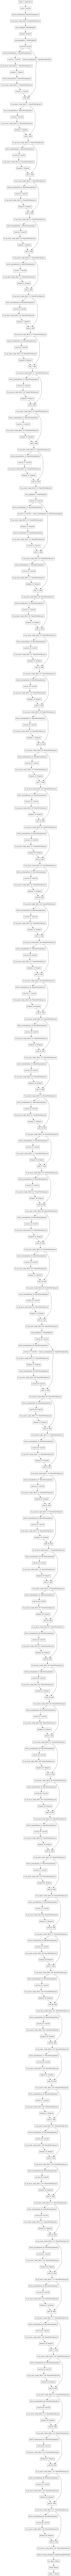

In [17]:
%%time
from keras.models import Model
from tensorflow import keras
#!pip install -q efficientnet
#import efficientnet.tfkeras as efn
with strategy.scope():
    
    out_ptron = len(CLASSES)
    model = hybridnet()


        
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()
from tensorflow.keras.utils import plot_model  #Plot the models for visualization
plot_model(model, to_file='model1.png')

## Fit your model and Submit your Output

In [18]:
%%time
history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, callbacks=[lr_callback],validation_data=get_validation_dataset())
model.save('cnnModel.h5')

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/100
99/99 [==============================] - 122s 1s/step - loss: 6.0209 - sparse_categorical_accuracy: 0.0436 - val_loss: 5.5243 - val_sparse_categorical_accuracy: 0.0345

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/100
99/99 [==============================] - 17s 174ms/step - loss: 4.2350 - sparse_categorical_accuracy: 0.1117 - val_loss: 4.9447 - val_sparse_categorical_accuracy: 0.0431

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/100
99/99 [==============================] - 18s 183ms/step - loss: 3.5536 - sparse_categorical_accuracy: 0.1692 - val_loss: 5.5211 - val_sparse_categorical_accuracy: 0.0280

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/100
99/99 [==============================] - 17s 175ms/step - loss: 3.2301 - sparse_categorical_accuracy: 0.2210 - val_loss: 5.6873 - val_sparse_

In [19]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

Score is low since we are not using any pretrained weights
CPU times: user 196 ms, sys: 123 ms, total: 319 ms
Wall time: 124 ms


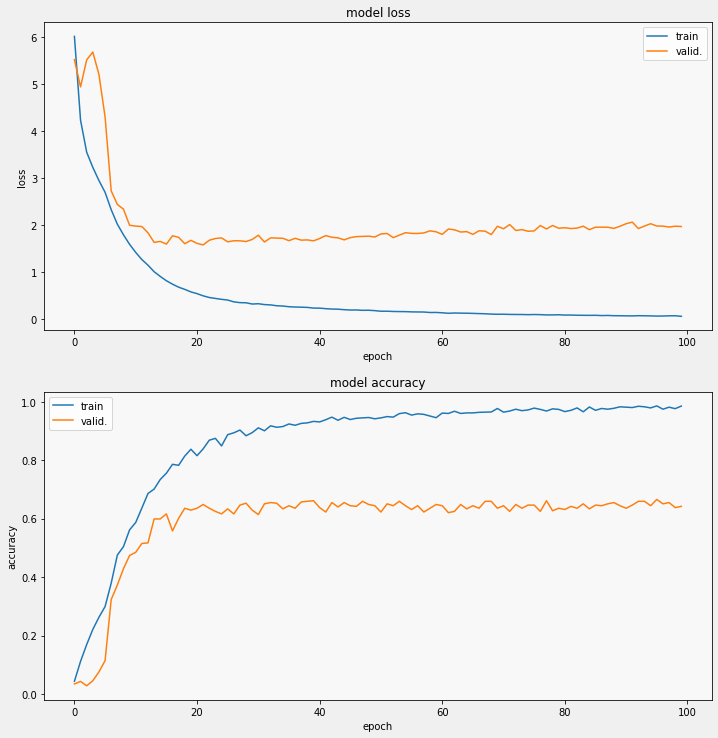

In [20]:
%%time
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)
print("Score is low since we are not using any pretrained weights")

In [21]:
%%time
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Computing predictions...
Cause: Unable to locate the source code of <function <lambda> at 0x7fefed2cf8c8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
[67 28 81 ...  4 14 53]
Generating submission.csv file...
Cause: Unable to locate the source code of <function <lambda> at 0x7fefe7542d90>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
CPU times: user 5.69 s, sys: 370 ms, total: 6.05 s
Wall time: 29.2 s
